In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [4]:
breakpoint_new=loadmat('./breakpoint_new.mat')
breakpoint_new.pop("__header__")
breakpoint_new.pop("__version__")
breakpoint_new.pop("__globals__")
breakpoint_raw=list(breakpoint_new.values())
store_slope=loadmat('./store_slope.mat')['store_slope']
neg_coe=store_slope[:,0].reshape(-1,1)
pos_coe=store_slope[:,1].reshape(-1,1)

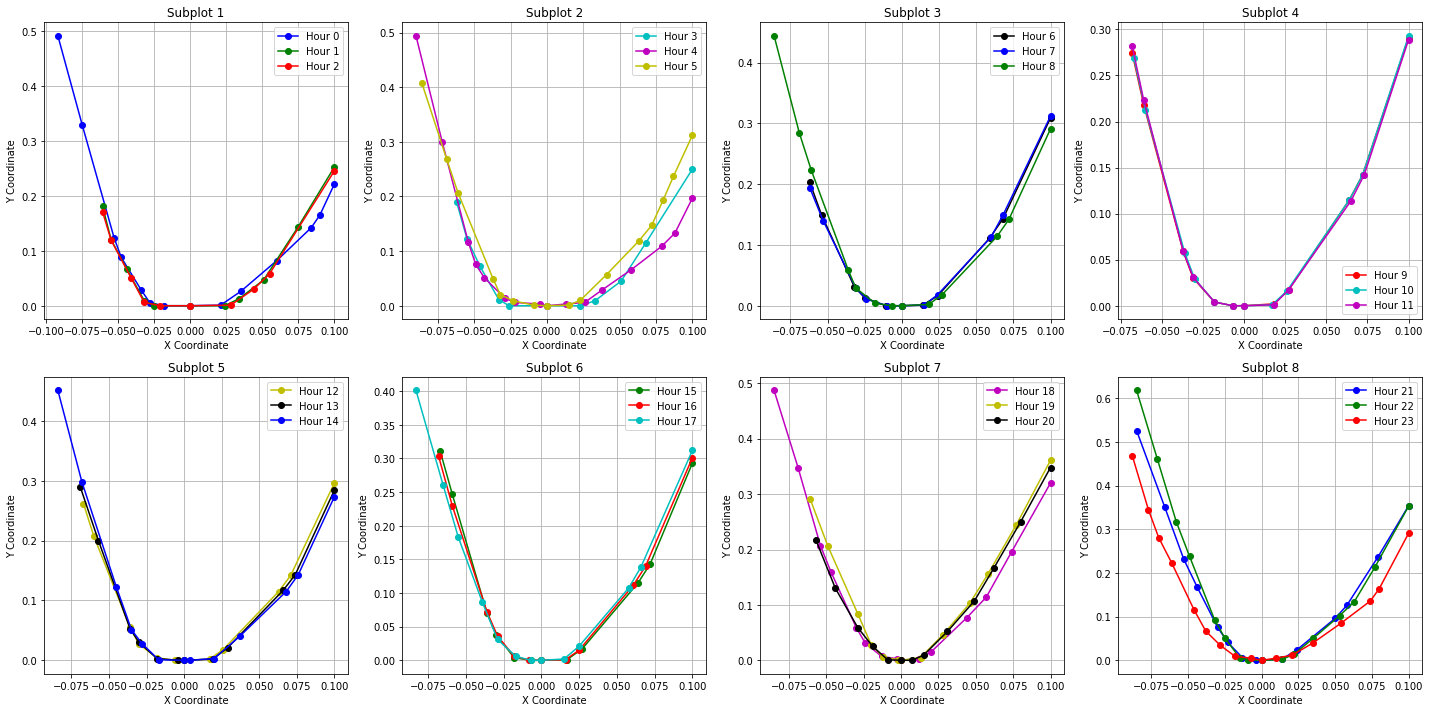

In [3]:
# 创建一个2行4列的子图画布
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# 定义颜色列表
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# 遍历每个子图
for subplot_index in range(8):
    # 在每个子图中绘制3个小时的数据
    for hour in range(3):
        hour_index = subplot_index * 3 + hour  # 计算当前小时的索引
        if hour_index >= 24:
            break  # 如果超过24小时，退出循环

        x = breakpoint_raw[hour_index][:, 0]
        y = breakpoint_raw[hour_index][:, 1]

        # 如果x坐标中没有0，添加(0, 0)
        if 0 not in x:
            x = np.append(x, 0)
            y = np.append(y, 0)
        sort_index = np.argsort(x)
        x = x[sort_index]
        y = y[sort_index]

        # 绘制线和点，使用不同的颜色
        axs[subplot_index // 4, subplot_index % 4].plot(x, y, marker='o', color=colors[hour_index % len(colors)], label=f'Hour {hour_index}')
    
    # 设置子图标题和标签
    axs[subplot_index // 4, subplot_index % 4].set_title(f'Subplot {subplot_index + 1}')
    axs[subplot_index // 4, subplot_index % 4].set_xlabel('X Coordinate')
    axs[subplot_index // 4, subplot_index % 4].set_ylabel('Y Coordinate')
    axs[subplot_index // 4, subplot_index % 4].grid()
    axs[subplot_index // 4, subplot_index % 4].legend()

# 调整布局
plt.tight_layout()
plt.show()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as co
from IPython.display import display
pd.options.mode.chained_assignment = None
import os, sys
dir1 = os.path.dirname(os.path.abspath(''))
if not dir1 in sys.path: sys.path.append(dir1)
plt.rcParams["figure.figsize"] = (15,5)
plt.style.use('seaborn-v0_8-darkgrid')
import pandas as pd
from utils import randomness, pytorchtools
import feature.feature_lag_selection as fls
import feature.feature_external_selection as fes
import feature.feature_transformation as ft
import feature.time_categorical as tc
import feature.time_stationarization as ts
import models.model_init as mi
import models.benchmark_init as bi
import evaluation.metrics as em
import postprocessing.quantile as ppq
import postprocessing.value as ppv
import datetime as dt
from forecast.scenario import calculate_scenario
import torch
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings("ignore")
import random

In [5]:
def setup_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [6]:
setup_seed(114)
site_id = "Cockatoo"
file_name = "load_with_temp.pkl"
# data = pd.read_pickle(f"../data/{site_id}/{file_name}")
data = pd.read_pickle('./load_with_weather.pkl')
target = ["load"]
quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
methods_to_train = [  
                  mi.PNBEATSX(pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7]),device),
                  mi.PTSMixerExt(pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7]),device),
                   mi.PBiTCN(pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7]),device),
                   mi.PTiDE(pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7]),device),
                    mi.PTFT(pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7]),device),
                    ]
horizon = 1  # or int(dt_resolution.seconds/data.index.freq.n)
train_ratio = 0.8
lags_list = list(range(1, 25))
preds_list = list(range(1, 24))
feature_transformation = ft.NoTransformationStrategy()
time_stationarization = ts.NoStationarizationStrategy()
datetime_features = [tc.Hour(),tc.Day(),tc.Weekday(),tc.Month()]
target_lag_selection = fls.ManualStrategy(lags=lags_list)
target_pred_selection = fls.ManualStrategy(lags=preds_list)
external_feature_selection = fes.LagStrategy({"airTemperature":fls.ManualStrategy(lags=lags_list)},
                                             {"airTemperature":fls.ManualStrategy(lags=preds_list)})
evaluation_metrics = [
                     em.MAE(),
                      ]
post_processing_quantile = ppq.QuantileSortingStrategy()
post_processing_value = ppv.ValueClippingStrategy(0, None)
save_results = False

err_tot, forecast_tot,true_tot = calculate_scenario(data=data,
                                            target=target,
                                            methods_to_train=methods_to_train,
                                            horizon=horizon,
                                            train_ratio=train_ratio,
                                            feature_transformation=feature_transformation,
                                            time_stationarization=time_stationarization,
                                            datetime_features=datetime_features,
                                            target_lag_selection=target_lag_selection,
                                            target_pred_selection=target_pred_selection,
                                            external_feature_selection=external_feature_selection,
                                            post_processing_quantile=post_processing_quantile,
                                            post_processing_value=post_processing_value,
                                            evaluation_metrics=evaluation_metrics,
                                            device=device,
                                            prob_forecasting=False)

Run time start: 2025-02-21 08:50:47.068707
PNBEATSX


train_loss 0.1877,val_loss 0.5301:  32%|███▏      | 16/50 [02:28<05:15,  9.29s/it]


Save the model
PTSMixerExt


train_loss 0.8850,val_loss 1.0641:  22%|██▏       | 11/50 [01:26<05:05,  7.84s/it]


Save the model
PBiTCN


train_loss 0.1683,val_loss 0.5692:  46%|████▌     | 23/50 [04:46<05:36, 12.46s/it]


Save the model
PTiDE


train_loss 1.0830,val_loss 1.1218: 100%|██████████| 50/50 [06:11<00:00,  7.43s/it]


Save the model
PTFT


train_loss 0.1100,val_loss 0.5887:  32%|███▏      | 16/50 [05:44<12:11, 21.52s/it]


Save the model
Run time end: 2025-02-21 09:11:28.800060
Run time duration [min]: 20.7


In [7]:
loss_function = pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7])

In [8]:
err_tot.keys()

dict_keys(['PNBEATSX', 'PTSMixerExt', 'PBiTCN', 'PTiDE', 'PTFT'])

In [9]:
print(loss_function(torch.Tensor(np.array(forecast_tot['PNBEATSX'])).reshape(-1),torch.Tensor(np.array(true_tot)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot['PTSMixerExt'])).reshape(-1),torch.Tensor(np.array(true_tot)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot['PBiTCN'])).reshape(-1),torch.Tensor(np.array(true_tot)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot['PTiDE'])).reshape(-1),torch.Tensor(np.array(true_tot)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot['PTFT'])).reshape(-1),torch.Tensor(np.array(true_tot)).reshape(-1)))

tensor(0.5130)
tensor(0.7758)
tensor(0.5261)
tensor(1.0422)
tensor(0.5811)


In [10]:
print(np.mean(err_tot['PNBEATSX']['MAE']))
print(np.mean(err_tot['PTSMixerExt']['MAE']))
print(np.mean(err_tot['PBiTCN']['MAE']))
print(np.mean(err_tot['PTiDE']['MAE']))
print(np.mean(err_tot['PTFT']['MAE']))

<xarray.DataArray ()>
array(0.12087874)
<xarray.DataArray ()>
array(0.16799161)
<xarray.DataArray ()>
array(0.12261141)
<xarray.DataArray ()>
array(0.21938272)
<xarray.DataArray ()>
array(0.13126165)


In [11]:
import pickle
with open(f"./err_tot14.pkl", 'wb') as f:
    pickle.dump(err_tot, f)
with open(f"./forecast_tot14.pkl", 'wb') as f:
    pickle.dump(forecast_tot, f)
with open(f"./true14.pkl", 'wb') as f:
    pickle.dump(true_tot, f)

In [12]:
setup_seed(114)
site_id = "Cockatoo"
file_name = "load_with_temp.pkl"
# data = pd.read_pickle(f"../data/{site_id}/{file_name}")
data = pd.read_pickle('./load_with_weather.pkl')

target = ["load"]
quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
methods_to_train = [  
                  mi.PNBEATSX(device = device),
                  mi.PTSMixerExt(device = device),
                   mi.PBiTCN(device = device),
                   mi.PTiDE(device = device ),
                    mi.PTFT(device = device),
                    ]
horizon = 1  # or int(dt_resolution.seconds/data.index.freq.n)
train_ratio = 0.8
lags_list = list(range(1, 25))
preds_list = list(range(1, 24))
feature_transformation = ft.NoTransformationStrategy()
time_stationarization = ts.NoStationarizationStrategy()
datetime_features = [tc.Hour(),tc.Day(),tc.Weekday(),tc.Month()]
target_lag_selection = fls.ManualStrategy(lags=lags_list)
target_pred_selection = fls.ManualStrategy(lags=preds_list)
external_feature_selection = fes.LagStrategy({"airTemperature":fls.ManualStrategy(lags=lags_list)},
                                             {"airTemperature":fls.ManualStrategy(lags=preds_list)})
evaluation_metrics = [
                     em.MAE(),
                      ]
post_processing_quantile = ppq.QuantileSortingStrategy()
post_processing_value = ppv.ValueClippingStrategy(0, None)
save_results = False

err_tot2, forecast_tot2,true_tot2 = calculate_scenario(data=data,
                                            target=target,
                                            methods_to_train=methods_to_train,
                                            horizon=horizon,
                                            train_ratio=train_ratio,
                                            feature_transformation=feature_transformation,
                                            time_stationarization=time_stationarization,
                                            datetime_features=datetime_features,
                                            target_lag_selection=target_lag_selection,
                                            target_pred_selection=target_pred_selection,
                                            external_feature_selection=external_feature_selection,
                                            post_processing_quantile=post_processing_quantile,
                                            post_processing_value=post_processing_value,
                                            evaluation_metrics=evaluation_metrics,
                                            device=device,
                                            prob_forecasting=False)

Run time start: 2025-02-21 09:11:28.913562
PNBEATSX


train_loss 0.0058,val_loss 0.0307:  36%|███▌      | 18/50 [02:29<04:25,  8.30s/it]


Save the model
PTSMixerExt


train_loss 0.0540,val_loss 0.0826:  32%|███▏      | 16/50 [01:34<03:21,  5.93s/it]


Save the model
PBiTCN


train_loss 0.0061,val_loss 0.0327:  42%|████▏     | 21/50 [03:40<05:04, 10.49s/it]


Save the model
PTiDE


train_loss 0.1042,val_loss 0.1124: 100%|██████████| 50/50 [04:19<00:00,  5.20s/it]


Save the model
PTFT


train_loss 0.0088,val_loss 0.0555:  22%|██▏       | 11/50 [04:08<14:39, 22.56s/it]


Save the model
Run time end: 2025-02-21 09:27:45.487879
Run time duration [min]: 16.28


In [13]:
print(loss_function(torch.Tensor(np.array(forecast_tot2['PNBEATSX'])).reshape(-1),torch.Tensor(np.array(true_tot2)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot2['PTSMixerExt'])).reshape(-1),torch.Tensor(np.array(true_tot2)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot2['PBiTCN'])).reshape(-1),torch.Tensor(np.array(true_tot2)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot2['PTiDE'])).reshape(-1),torch.Tensor(np.array(true_tot2)).reshape(-1)))
print(loss_function(torch.Tensor(np.array(forecast_tot2['PTFT'])).reshape(-1),torch.Tensor(np.array(true_tot2)).reshape(-1)))

tensor(0.5459)
tensor(0.7330)
tensor(0.5703)
tensor(1.0477)
tensor(0.9104)


In [14]:
print(np.mean(err_tot2['PNBEATSX']['MAE']))
print(np.mean(err_tot2['PTSMixerExt']['MAE']))
print(np.mean(err_tot2['PBiTCN']['MAE']))
print(np.mean(err_tot2['PTiDE']['MAE']))
print(np.mean(err_tot2['PTFT']['MAE']))

<xarray.DataArray ()>
array(0.1239241)
<xarray.DataArray ()>
array(0.15858785)
<xarray.DataArray ()>
array(0.13213689)
<xarray.DataArray ()>
array(0.22157665)
<xarray.DataArray ()>
array(0.18882492)


In [15]:
import pickle
with open(f"./err_tot142.pkl", 'wb') as f:
    pickle.dump(err_tot2, f)
with open(f"./forecast_tot142.pkl", 'wb') as f:
    pickle.dump(forecast_tot2, f)
with open(f"./true142.pkl", 'wb') as f:
    pickle.dump(true_tot2, f)

In [28]:
loss_function = pytorchtools.ContinuousPiecewiseLinearFunction(breakpoint_raw[7])

In [29]:
model_list = ['PNBEATSX', 'PTSMixerExt', 'PBiTCN', 'PTiDE', 'PTFT']

In [45]:
true_ours = []
forecast_ours = []
forecast = []
true = []
qq = 4
for i in range(100,103):
    forecast_ours.append(torch.Tensor(np.array(pd.read_pickle('./forecast_ours_'+str(i)+'.pkl')[model_list[qq]])).reshape(-1))
    true_ours.append(torch.Tensor(np.array(pd.read_pickle('./true_ours_'+str(i)+'.pkl'))).reshape(-1))
    forecast.append(torch.Tensor(np.array(pd.read_pickle('./forecast_'+str(i)+'.pkl')[model_list[qq]])).reshape(-1))
    true.append(torch.Tensor(np.array(pd.read_pickle('./true_'+str(i)+'.pkl'))).reshape(-1))

In [46]:
err_ours  =[]
err = []
for j in range(3):
    err_ours.append(np.array(loss_function(forecast_ours[j],true_ours[j])))
    err.append(np.array(loss_function(forecast[j],true[j])))

In [47]:
print(np.mean(err_ours))
print(np.mean(err))

0.68173003
0.706834


In [ ]:
def PEC(true,pred):
    return((pred-true)/true)

In [ ]:
def fun_y(x):
    y = []
    for i in range(len(x)):
        if x[i]<=-0.05:
            q = float(72*x[i]**8+128*x[i]**6+16*x[i]**4+44*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>1:
                y.append(1)
            else:
                y.append(q)
        elif x[i]<=-0.02:
            q = float(72*x[i]**8+64*x[i]**6+16*x[i]**4+36*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>=1:
                y.append(1)
            else:
                y.append(q)
        elif x[i]<=-0.01:
            q = float(72*x[i]**8+48*x[i]**6+14*x[i]**4+36*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>=1:
                y.append(1)
            else:
                y.append(q)
        elif x[i]<=0:
            q = float(24*x[i]**8+24*x[i]**6+12*x[i]**4+36*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>=1:
                y.append(1)
            else:
                y.append(q)
        elif x[i]<=0.02:
            q = float(24*x[i]**8+24*x[i]**6+12*x[i]**4+34*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>=1:
                y.append(1)
            else:
                y.append(q)
        elif x[i]<=0.1:
            q = float(24*x[i]**8+20*x[i]**6+12*x[i]**4+30*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>=1:
                y.append(1)
            else:
                y.append(q)
        else:
            q = float(20*x[i]**8+20*x[i]**6+12*x[i]**4+16*x[i]**3+32*x[i]**2+np.random.normal(0,0.005,1))
            if q<=0:
                y.append(0)
            elif q>=1:
                y.append(1)
            else:
                y.append(q)
        
    return y
    
        

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import cumtrapz

# 生成数据
qx = np.random.uniform(-0.15, 0.15, 5000)
qy = fun_y(qx)
df = pd.DataFrame({'col1': qx, 'col2': qy})
df = df.sort_values(by='col1')
# df.to_csv('./simulated_data.csv',index=False)
qx = df.iloc[:,0]
qy = df.iloc[:,1]
# 进行样条函数拟合
spline = UnivariateSpline(qx, qy, k = 3,s=0.5)

# 绘制原始数据和拟合曲线
plt.plot(qx, qy, 'o', label='data')
plt.plot(qx, spline(qx), label='Cubic Spline')

plt.legend()
plt.show()

In [ ]:
vv = np.random.uniform(-1 ,1, 100)
plt.plot(vv, spline(vv),'o', label='Cubic Spline')

In [ ]:
threshold = 0.15

In [ ]:
length = 15000
K_x = np.random.uniform(-threshold, threshold, length)
K_x.sort()
K_y_smooth_2 = spline.derivative(n=2)(K_x)
K_yy = np.power(K_y_smooth_2,2/5)
# 使用cumtrapz函数计算累积积分
K_y_int = cumtrapz(K_yy, K_x, axis=0, initial=0)
K_y_int = np.power(K_y_int,5/2)

In [ ]:
for i in range(1,500):
    if K_y_int[-1]/(np.sqrt(120)*(i**2))<=0.005:
        print(i)
        K=i
        break

In [ ]:
point = []
point.append(-threshold)
all_x = np.random.uniform(-threshold, threshold, length)
all_x.sort()
all_y_smooth_2 = spline.derivative(n=2)(all_x)
all_yy = np.power(np.abs(all_y_smooth_2),2/5)
all = cumtrapz(all_yy, all_x, axis=0, initial=0)[-1]
for i,k in enumerate(np.linspace(-threshold,threshold,length*10)):
    if len(point)==K:
        break
    else:
        start_point = point[-1]
        end_point = k
        x = np.linspace(start_point,end_point,length)
        y = spline.derivative(n=2)(x)
        yy = np.power(np.abs(y),2/5)
        iter = (cumtrapz(yy, x, axis=0, initial=0)[-1])/all
        if np.abs(iter-1/K)<=0.0001:
            point.append(end_point)
        

In [ ]:
start_point = point[-1]
# end_point = point[-1]
end_point = 0.15
x = np.linspace(start_point,end_point,150000)
y = spline.derivative(n=2)(x)
yy = np.power(np.abs(y),2/5)
iter = (cumtrapz(yy, x, axis=0, initial=0)[-1])/all
print(iter)

In [ ]:
1/K

In [ ]:
point.pop(0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
X = np.array(df.iloc[:,0])
Y = np.array(df.iloc[:,1])

# 分段点
break_points = point

# 根据分段点将数据分组
segments = [(X < break_points[0])]
for i in range(1, len(break_points)):
    mask = (X >= break_points[i-1]) & (X < break_points[i])
    segments.append(mask)

segments.append(X >= break_points[-1])

# 对每个部分进行线性拟合
linear_models = []
for mask in segments:
    X_part = X[mask]
    Y_part = Y[mask]
    model = np.polyfit(X_part, Y_part, 1)
    linear_models.append(model)

# 预测
def predict(x):
    for i, (m, b) in enumerate(linear_models):
        if x < break_points[i]:
            return m * x + b
        if i == len(break_points) - 1:
            break
    return linear_models[-1][0] * x + linear_models[-1][1]

# 计算MSE
mse = np.mean([(predict(x) - y)**2 for x, y in zip(X, Y)])
print("均方误差（MSE）：", mse)

# 可视化结果
plt.scatter(X, Y, color='blue', label='Data points')
x_vals1 = np.linspace(min(X), max(X), 100)
y_vals1 = [predict(x) for x in x_vals]
plt.plot(x_vals1, y_vals1, color='red', label='Piecewise linear fit')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Piecewise Linear Fit')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
X = np.array(df.iloc[:,0])
Y = np.array(df.iloc[:,1])

# 分段点
break_points = point

# 指定重叠区域宽度
overlap = 0.000001

# 对每个部分进行线性拟合
linear_models = []
for i in range(len(break_points) + 1):
    if i == 0:
        mask = X < break_points[i]
    elif i == len(break_points):
        mask = X >= break_points[i - 1]
    else:
        mask = (X >= break_points[i - 1]) & (X < break_points[i])

    X_part = X[mask]
    Y_part = Y[mask]
    model = np.polyfit(X_part, Y_part, 1)
    linear_models.append(model)

# 在间断点附近构建二次函数
quadratic_models = []
for i in range(1, len(linear_models)):
    m1, b1 = linear_models[i - 1]
    m2, b2 = linear_models[i]
    x0 = break_points[i - 1]

    # 二次函数的系数
    a = (m2 - m1) / (4 * overlap)
    b = m1 - 2 * a * (x0 - overlap)
    c = m1 * (x0 - overlap) + b1 - a * (x0 - overlap)**2 - b * (x0 - overlap)

    quadratic_models.append((a, b, c))

# 预测函数
def predict(x):
    for i, (m, b) in enumerate(linear_models):
        if x < break_points[i] - overlap:
            return m * x + b
        elif x < break_points[i] + overlap:
            a, b, c = quadratic_models[i - 1]
            return a * x**2 + b * x + c
        if i == len(break_points) - 1:
            break
    return linear_models[-1][0] * x + linear_models[-1][1]

# 计算MSE
mse = np.mean([(predict(x) - y)**2 for x, y in zip(X, Y)])
print("均方误差（MSE）：", mse)

# 可视化结果
plt.scatter(X, Y, color='blue', label='Data points')
x_vals = np.linspace(min(X), max(X), 100)
y_vals = [predict(x) for x in x_vals]
plt.plot(x_vals, y_vals, color='red', label='Continuous piecewise linear and quadratic fit')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Continuous Piecewise Linear and Quadratic Fit')
plt.show()

In [ ]:
error = [(predict(x) - y)**2 for x, y in zip(X, Y)]

In [ ]:
plt.plot(error)

In [ ]:
# 创建一行三列的子图
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # figsize 调整整个图的大小

lighter_gray = "#F0F0F0"
for ax in axs:
    # 设置子图的背景颜色为浅灰色
    ax.set_facecolor(lighter_gray)
    
    # 在子图上添加网格
    ax.grid(True)


# 在子图 1 中绘制数据


axs[0].plot(qx, qy, 'o', label='data')
axs[0].plot(qx, spline(qx), label='Cubic Spline')
axs[0].set_title("Cubic Spline")
axs[0].legend(fontsize=6)

# 在子图 2 中绘制数据
axs[1].scatter(X, Y, color='blue', label='Data points')
x_vals1 = np.linspace(min(X), max(X), 100)
y_vals1 = [predict(x) for x in x_vals]
axs[1].plot(x_vals1, y_vals1, color='red', label='Piecewise linear fit')
axs[1].legend(fontsize=6)
axs[1].set_title("Piecewise linear")

# 在子图 3 中绘制数据
axs[2].scatter(X, Y, color='purple', label='Data points')
x_vals = np.linspace(min(X), max(X), 100)
y_vals = [predict(x) for x in x_vals]
axs[2].plot(x_vals, y_vals, color='red', label='Continuous piecewise linear and quadratic fit')
axs[2].legend(fontsize=6)
axs[2].set_title("Continuous piecewise linear and quadratic fit")

# 添加整个图的标题
# fig.suptitle("Different data fitting methods")

# 调整子图之间的间距
fig.subplots_adjust(wspace=0.3)
fig.savefig("./fitted.pdf",bbox_inches='tight')
# 显示图形
plt.show()